# 基本信息
1. 实验名称：实验2 前馈神经网络实验
2. 姓名：
3. 学号：
4. 日期：2022年10月14日

---

# 1.手动回归
>  基本情况说明
>> 数据集为按照实验要求人工生成，手动实现和利用torch.nn实现的，数据集相同
>> 基本代码思路主要按照课程上讲解思路和实验指导中的代码示例，比较简单，不详细展开

In [1]:
# 生成数据集
import torch.nn
import torch
import torchvision
import numpy as np


In [2]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 0.01, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.ones((500, 1)) * 0.0056
true_b = 0.028
features, labels = synthetic_data(true_w, true_b, 10000)


In [4]:
features.shape

torch.Size([10000, 500])

In [3]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i+ batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [4]:
def train_test_split_simple(features, lables, train_size):
    num_example = len(features)
    indices = list(range(num_example))
    random.shuffle(indices)
    return features[indices[0:int(num_example*train_size)]], features[indices[int(num_example*(train_size)):]],  \
           lables[indices[0:int(num_example*train_size)]], lables[indices[int(num_example*train_size):]]

In [5]:
x_train, x_test, y_train, y_test = train_test_split_simple(features, labels, train_size=0.7)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([7000, 500])
torch.Size([3000, 500])
torch.Size([7000, 1])
torch.Size([3000, 1])


In [6]:
w = torch.normal(0, 0.01, size=(500, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [7]:
def NetLinearRegression(X, w, b):
    z = torch.matmul(X, w) + b
    # activation func Relu
    a = torch.max(input=z, other=torch.tensor(0.0))
    return a

# 线性回归使用均方损失
def squared_loss(y_hat, y):
    # print(y_hat.shape)
    # print(y.shape)
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
# mini batch random gradient descent
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param.data -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
print(x_train.shape)
print(y_train.shape)

torch.Size([7000, 500])
torch.Size([7000, 1])


In [8]:
class NetNeuralNetwork:
    def __init__(self, num_input, num_hidden, num_output):
        W1 = torch.tensor(np.random.normal(0, 0.01,(num_hidden, num_input)),  dtype=torch.float32, requires_grad=True)
        b1 = torch.zeros(num_hidden, dtype=torch.float32, requires_grad=True)
        W2 = torch.tensor(np.random.normal(0,0.01, (num_output, num_hidden)), dtype=torch.float32, requires_grad=True)
        b2 = torch.zeros(num_output, dtype=torch.float32, requires_grad=True)

        self.input_layer = lambda x: x.view(x.shape[0], -1)

        self.hidden_layer = lambda x: self.my_Relu(torch.matmul(x, W1.t()) + b1)
        self.output_layer = lambda x: torch.matmul(x, W2.t()) + b2
        self.params = [W1, b1, W2, b2]

    def my_Relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))

    def forward(self,x):
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        return final_output


In [9]:
def my_cross_entropy_loss(y_hat, labels):
    def log_softmax(y_hat):
        max_v = torch.max(y_hat, dim=1).values.unsqueeze(dim=1)
        return y_hat-max_v - torch.log(torch.exp(y_hat-max_v).sum(dim=1)).unsqueeze(dim=1)
    return (-log_softmax(y_hat))[range(len(y_hat)), labels].mean()

In [10]:
def evaluate_accuracy_classifier(data_iter, model, loss_func):
    acc_sum, test_l_sum, n, c = 0.0, 0.0, 0, 0
    for X, y in data_iter:
        result = model.forward(X)
        acc_sum += (result.argmax(dim=1) == y).float().sum().item()
        test_l_sum += loss_func(result, y).item()
        n += y.shape[0]
        c += 1
    return acc_sum/n, test_l_sum/c

In [15]:
print(x_train.shape)
print(w.shape)
print(NetLinearRegression(x_train, w, b))

torch.Size([7000, 500])
torch.Size([500, 1])
tensor([[0.0007],
        [0.0009],
        [0.0000],
        ...,
        [0.0000],
        [0.0000],
        [0.0011]], grad_fn=<MaximumBackward0>)


In [11]:
import time
import matplotlib.pyplot as plt


w = torch.normal(0, 0.01, size=(500, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


def train_regress(net, loss, x_train, x_test, y_train, y_test, epochs, lr, batch_size, name_net):
    train_loss_ls = []
    test_loss_ls = []
    for epoch in range(epochs):
        for X, y in data_iter(batch_size, x_train, y_train):
            # print(y_train.shape)
            y_hat = net.forward(X)

            l = loss(y_hat, y)
            # print(y_hat)
            l.sum().backward()
            # todo
            sgd(net.params, lr, batch_size)
        with torch.no_grad():
            # need to be summed
            train_loss = loss(net.forward(x_train), y_train).mean()
            test_loss = loss(net.forward(x_test), y_test).mean()
            train_loss_ls.append(train_loss)
            test_loss_ls.append(test_loss)
            print('epochs', "%d" %(epoch+1), "train_loss", "%.4f" %train_loss, "test_loss", "%.4f"%test_loss)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(test_loss_ls, label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


epochs 1 train_loss 0.0001 test_loss 0.0001
epochs 2 train_loss 0.0001 test_loss 0.0001
epochs 3 train_loss 0.0001 test_loss 0.0001
epochs 4 train_loss 0.0001 test_loss 0.0001
epochs 5 train_loss 0.0001 test_loss 0.0000
epochs 6 train_loss 0.0000 test_loss 0.0000
epochs 7 train_loss 0.0000 test_loss 0.0000
epochs 8 train_loss 0.0000 test_loss 0.0000
epochs 9 train_loss 0.0000 test_loss 0.0000
epochs 10 train_loss 0.0000 test_loss 0.0000


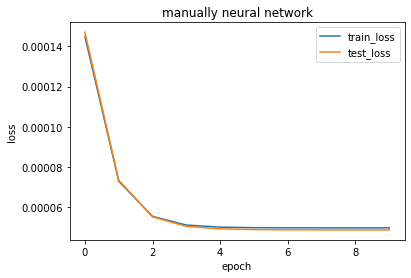

running time 1.7815287113189697


In [12]:
lr = 0.01
epochs = 10
net = NetNeuralNetwork(500, 256, 1)
loss = squared_loss
batch_size = 100

start = time.time()
train_regress(net, loss, x_train, x_test, y_train, y_test, epochs, lr, batch_size, "manually neural network")
end = time.time()

print("running time", (end-start))

> 实验结果说明：
> 回归任务直接用均方误差的结果表现精度。具体结果见上图。


# 2.torch.nn实现回归

In [13]:
import torch.nn as nn
import torch

In [14]:
class NetNeuralNetworkWithNN:
    def __init__(self, num_input, num_hidden, num_output):
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_input, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_output)
        )

        for m in self.layer:
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=0.01)

    def forward(self, x):
        return self.layer(x)

In [15]:
def train_regress_withNN(net, loss, x_train, x_test, y_train, y_test, epochs, batch_size, optimizer,name_net):
    train_loss_ls = []
    test_loss_ls = []
    for epoch in range(epochs):
        for X, y in data_iter(batch_size, x_train, y_train):
            # print(y_train.shape)
            optimizer.zero_grad()
            y_hat = net.forward(X)
            l = loss(y_hat, y)
            # print(l)
            # print(y_hat)
            l.backward()
            # todo
            optimizer.step()

        with torch.no_grad():
            # need to be summed
            train_loss = loss(net.forward(x_train), y_train).mean()
            test_loss = loss(net.forward(x_test), y_test).mean()
            train_loss_ls.append(train_loss)
            test_loss_ls.append(test_loss)
            print('epochs', "%d" %(epoch+1), "train_loss", "%.4f" %train_loss, "test_loss", "%.4f"%test_loss)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(test_loss_ls, label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
import time

epochs 1 train_loss 0.0004 test_loss 0.0004
epochs 2 train_loss 0.0001 test_loss 0.0001
epochs 3 train_loss 0.0001 test_loss 0.0001
epochs 4 train_loss 0.0001 test_loss 0.0001
epochs 5 train_loss 0.0001 test_loss 0.0001
epochs 6 train_loss 0.0001 test_loss 0.0001
epochs 7 train_loss 0.0001 test_loss 0.0001
epochs 8 train_loss 0.0001 test_loss 0.0001
epochs 9 train_loss 0.0001 test_loss 0.0001
epochs 10 train_loss 0.0001 test_loss 0.0001


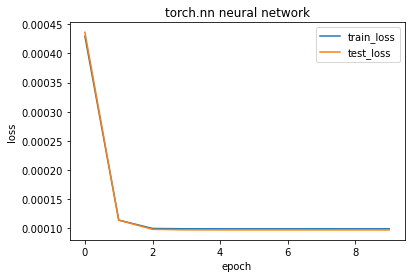

running time 1.26399564743042


In [16]:
lr = 0.01
epochs = 10
net = NetNeuralNetworkWithNN(500, 256, 1)
loss = nn.MSELoss()

start = time.time()

optimizer = torch.optim.SGD(params=net.layer.parameters(), lr=lr)
batch_size = 100

train_regress_withNN(net, loss, x_train, x_test, y_train, y_test, epochs, batch_size, optimizer, "torch.nn neural network")
end = time.time()

print("running time", (end-start))

# 3.手动二分类

## 3.1 基本函数编写

In [227]:
import torch
import torch.nn as nn


In [228]:
x_positive = torch.normal(mean=1.0, std=0.01, size=(10000, 200), dtype=torch.float32)
x_negative = torch.normal(mean=-1.0, std=0.01, size=(10000, 200), dtype=torch.float32)
y_positive = torch.ones(size=(10000, 1), dtype=torch.int32)
y_negative = torch.zeros(size=(10000, 1), dtype=torch.int32)
X = torch.cat([x_positive, x_negative], dim=0)
Y = torch.cat([y_positive, y_negative], dim=0)

In [229]:
def train_test_split_simple(features, lables, train_size):
    num_example = len(features)
    indices = list(range(num_example))
    random.shuffle(indices)
    return features[indices[0:int(num_example*train_size)]], features[indices[int(num_example*(train_size)):]],  \
           lables[indices[0:int(num_example*train_size)]], lables[indices[int(num_example*train_size):]]

In [230]:
x_train, x_test, y_train, y_test = train_test_split_simple(X, Y, train_size=0.7)

In [231]:
class NetBinaryClassifier:
    def __init__(self, num_input, num_hidden, num_output, last_act="Relu"):
        W1 = torch.tensor(np.random.normal(0, 0.01,(num_hidden, num_input)),  dtype=torch.float32, requires_grad=True)
        b1 = torch.zeros(num_hidden, dtype=torch.float32, requires_grad=True)
        W2 = torch.tensor(np.random.normal(0,0.01, (num_output, num_hidden)), dtype=torch.float32, requires_grad=True)
        b2 = torch.zeros(num_output, dtype=torch.float32, requires_grad=True)

        self.input_layer = lambda x: x.view(x.shape[0], -1)

        self.hidden_layer = lambda x: self.my_Relu(torch.matmul(x, W1.t()) + b1)
        self.output_layer = lambda x: torch.matmul(x, W2.t()) + b2
        self.params = [W1, b1, W2, b2]
        self.last_act = last_act
    def my_Relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))


    def forward(self,x):
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        if self.last_act == "Sigmoid":
            final_output = torch.sigmoid(final_output)
        else:
            final_output = self.my_Relu(final_output)
        return final_output

In [232]:
def evaluate_acc_binary_classifier(y_hat:torch.tensor, y):
    def change(x):
        if x>=0.5:
            return 1
        else:
            return 0

    result = y_hat.apply_(change)
    # print(result)
    # print(y==result)
    acc = (result==y).float().sum().item()/ y.shape[0]
    # print(acc)
    return acc


In [234]:
def CrossEntropy_my(y_hat, y):
    # print(y_hat)
    # y_hat = torch.clamp(y_hat, 1e-20, 1-(1e-20))
    result = -y*torch.log(y_hat) - (1-y)*torch.log(1-y_hat)
    return result

In [235]:
def train_binary_classifier(net, loss, x_train, x_test, y_train, y_test, epochs, lr, batch_size,eval, name_net, ):
    def forward(x):
        y_hat = x
        for i in net:
            y_hat = i.forward(y_hat)
        return y_hat

    def get_params(net):
        param_ls = []
        for i in net:
            param_ls += i.params
        return param_ls


    train_loss_ls = []
    test_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
        for X, y in data_iter(batch_size, x_train, y_train):
            y_hat = forward(X)
            l = loss(y_hat, y).sum()
            l.backward()

            sgd(get_params(net), lr, batch_size)
        with torch.no_grad():
            # need to be summed
            y_hat = forward(x_train)
            acc_train = eval(y_hat, y_train)

            train_loss = loss(y_hat, y_train).mean()

            y_hat = forward(x_test)
            test_loss = loss(y_hat, y_test).mean()
            acc_test = eval(y_hat, y_test)

            # train_loss = torch.clamp(train_loss, 1e-10, 1)

            train_loss_ls.append(train_loss)
            test_loss_ls.append(test_loss)
            acc_train_ls.append(acc_train)
            acc_test_ls.append(acc_test)
            print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" % train_loss, "test_loss", "%.4f" % test_loss, "train_acc","%.4f"%acc_train, "test_acc", "%.4f"%acc_test)
            # print("try acc", accuracy_score(y_test, y_hat))
    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(test_loss_ls, label='test_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    # print(train_loss_ls)


## 3.2 采用交叉熵损失
### 3.2.1 调用模块

In [238]:
import time

epochs 1 train_loss nan test_loss 0.6925 train_acc 0.5004 test_acc 0.4990
epochs 2 train_loss nan test_loss 0.0347 train_acc 1.0000 test_acc 1.0000
epochs 3 train_loss nan test_loss 0.0006 train_acc 1.0000 test_acc 1.0000
epochs 4 train_loss nan test_loss 0.0003 train_acc 1.0000 test_acc 1.0000
epochs 5 train_loss nan test_loss 0.0002 train_acc 1.0000 test_acc 1.0000
epochs 6 train_loss nan test_loss 0.0001 train_acc 1.0000 test_acc 1.0000
epochs 7 train_loss nan test_loss 0.0001 train_acc 1.0000 test_acc 1.0000
epochs 8 train_loss nan test_loss 0.0001 train_acc 1.0000 test_acc 1.0000
epochs 9 train_loss nan test_loss 0.0001 train_acc 1.0000 test_acc 1.0000
epochs 10 train_loss nan test_loss 0.0000 train_acc 1.0000 test_acc 1.0000
epochs 11 train_loss nan test_loss 0.0000 train_acc 1.0000 test_acc 1.0000
epochs 12 train_loss nan test_loss 0.0000 train_acc 1.0000 test_acc 1.0000
epochs 13 train_loss nan test_loss 0.0000 train_acc 1.0000 test_acc 1.0000
epochs 14 train_loss nan test_loss

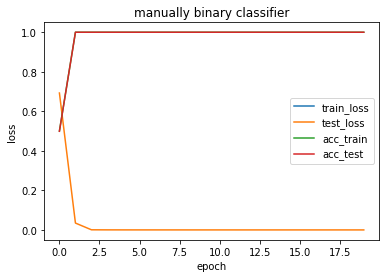

running time 6.170657396316528


In [240]:
start = time.time()
lr = 0.1
epochs = 20
net1 = NetBinaryClassifier(200, 150, 100)
net2 = NetBinaryClassifier(100, 50, 1, "Sigmoid")
loss = CrossEntropy_my
net = [net1, net2]
batch_size = 100
eval = evaluate_acc_binary_classifier
train_binary_classifier(net, loss, x_train, x_test, y_train, y_test, epochs, lr, batch_size, eval, "manually binary classifier")

end = time.time()
print("running time", (end-start))

### 3.2.2交叉熵损失结果分析
交叉熵损失中中调用torch.log 函数 可以出现超出定义域的情况，所以train loss 为nan> 结果说明：
结果回顾时，才发现分类任务中加入了 所谓和回归任务中一样的test loss，实际是不需要的，特此说明。

## 3.3 采用均方误差损失
### 3.3.1 调用模块

In [241]:
import time

epochs 1 train_loss 0.2502 test_loss 0.1250 train_acc 0.4996 test_acc 0.5010
epochs 2 train_loss 0.2502 test_loss 0.1250 train_acc 0.4996 test_acc 0.5010
epochs 3 train_loss 0.2502 test_loss 0.1249 train_acc 0.4996 test_acc 0.5010
epochs 4 train_loss 0.0000 test_loss 0.1249 train_acc 1.0000 test_acc 1.0000
epochs 5 train_loss 0.2502 test_loss 0.1247 train_acc 0.4996 test_acc 0.5010
epochs 6 train_loss 0.0000 test_loss 0.1242 train_acc 1.0000 test_acc 1.0000
epochs 7 train_loss 0.0000 test_loss 0.1208 train_acc 1.0000 test_acc 1.0000
epochs 8 train_loss 0.0000 test_loss 0.0202 train_acc 1.0000 test_acc 1.0000
epochs 9 train_loss 0.0000 test_loss 0.0006 train_acc 1.0000 test_acc 1.0000
epochs 10 train_loss 0.0000 test_loss 0.0002 train_acc 1.0000 test_acc 1.0000
epochs 11 train_loss 0.0000 test_loss 0.0001 train_acc 1.0000 test_acc 1.0000
epochs 12 train_loss 0.0000 test_loss 0.0001 train_acc 1.0000 test_acc 1.0000
epochs 13 train_loss 0.0000 test_loss 0.0001 train_acc 1.0000 test_acc 1.

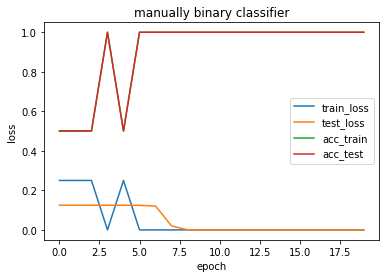

running time 6.602993726730347


In [242]:
start = time.time()

lr = 0.1
epochs = 20
net1 = NetBinaryClassifier(200, 150, 100)
net2 = NetBinaryClassifier(100, 50, 1, "Sigmoid")
loss = squared_loss
net = [net1, net2]
batch_size = 100
eval = evaluate_acc_binary_classifier
train_binary_classifier(net, loss, x_train, x_test, y_train, y_test, epochs, lr, batch_size, eval, "manually binary classifier")

end = time.time()
print("running time", (end- start))

### 3.3.2 均方误差结果分析
均方误差不会出现nan的情况，但是相对于交叉熵损失，收敛比较慢，均方是6.6s，交叉熵为6.2s。而且，均方损失不够稳定，图像上下跳跃。

# 4. torch.nn实现二分类
## 4.1 基本代码编写

In [5]:
import torch
import torch.nn as nn
import random

In [93]:
x_positive = torch.normal(mean=100.0, std=0.01, size=(10000, 200), dtype=torch.float32)
x_negative = torch.normal(mean=-100.0, std=0.01, size=(10000, 200), dtype=torch.float32)
y_positive = torch.ones(size=(10000, 1), dtype=torch.float32)
y_negative = torch.zeros(size=(10000, 1), dtype=torch.float32)
X = torch.cat([x_positive, x_negative], dim=0)
Y = torch.cat([y_positive, y_negative], dim=0)

In [73]:
def train_test_split_simple(features, lables, train_size):
    num_example = len(features)
    indices = list(range(num_example))
    random.shuffle(indices)
    return features[indices[0:int(num_example*train_size)]], features[indices[int(num_example*(train_size)):]],  \
           lables[indices[0:int(num_example*train_size)]], lables[indices[int(num_example*train_size):]]

In [94]:
x_train, x_test, y_train, y_test = train_test_split_simple(X, Y, train_size=0.7)

In [82]:
def evaluate_acc_binary_classifier(y_hat:torch.tensor, y):
    def change(x):
        with torch.no_grad():
            if x>=0.5:
                return 1
            else:
                return 0

    with torch.no_grad():
        result = y_hat.detach().apply_(change)
        # print(result)
        # print(y==result)
        acc = (result==y).float().sum()/ y.shape[0]
    # print(acc)
    return acc.item()

In [8]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i+ batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [103]:
def train_binary_classifier_withNN(net, loss, x_train, x_test, y_train, y_test, epochs, batch_size,optimizer,eval, name_net):
    train_loss_ls = []
    # test_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []

    for epoch in range(epochs):
        for X, y in data_iter(batch_size, x_train, y_train):
            y_hat = net(X)
            # print(y_hat[:, 0])
            l = loss(y_hat, y).mean()

            optimizer.zero_grad()
            l.backward()
            optimizer.step()


        with torch.no_grad():
            # need to be summed
            y_hat = net(x_train)
            train_loss = loss(y_hat, y_train).mean()
            acc_train = eval(y_hat, y_train)
            y_hat = net(x_test)
            # test_loss = loss(y_hat, y_test).mean()
            acc_test = eval(y_hat, y_test)

            train_loss_ls.append(train_loss)
            # test_loss_ls.append(test_loss)
            acc_train_ls.append(acc_train)
            acc_test_ls.append(acc_test)
            # print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" % train_loss, "test_loss", "%.4f" % test_loss, "train_acc","%.4f"%acc_train, "test_acc", "%.4f"%acc_test)
            print('epochs', epoch+1, "train_loss", train_loss.item(), "train_acc", acc_train, "test_loss", acc_test)
    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    # plt.plot(test_loss_ls, label='test_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

## 4.2 函数调用
### 4.2.1 调用模块

In [12]:
import time
import matplotlib.pyplot as plt

epochs 1 train_loss 2.971291479525462e-08 train_acc 1.0 test_loss 1.0
epochs 2 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 3 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 4 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 5 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 6 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 7 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 8 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 9 train_loss 0.0 train_acc 1.0 test_loss 1.0
epochs 10 train_loss 0.0 train_acc 1.0 test_loss 1.0


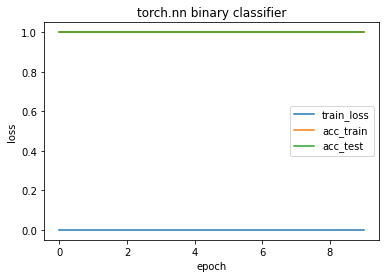

running time 1.3989982604980469


In [104]:
NetBinaryClassifierWithNN = nn.Sequential(
    nn.Flatten(),
    nn.Linear(200, 1),
    nn.Sigmoid()
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

NetBinaryClassifierWithNN.apply(init_weights)

start = time.time()

lr = 0.1
epochs = 10
net = NetBinaryClassifierWithNN

loss = nn.BCELoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
batch_size = 100
eval = evaluate_acc_binary_classifier

train_binary_classifier_withNN(net, loss, x_train, x_test, y_train, y_test, epochs, batch_size, optimizer, eval,'torch.nn binary classifier')

end= time.time()
print("running time", (end-start))

### 4.2.2 结果分析
在第一个epoch中即可做到完全拟合，人工数据集还是比较好拟合。这里的情况比较特殊，本人采用了下边的模块进行辨析。

In [106]:
def train_binary_classifier_withNN_try(net, loss, x_train, x_test, y_train, y_test, epochs, batch_size,optimizer,eval, name_net):
    train_loss_ls = []
    # test_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []

    for epoch in range(epochs):
        for X, y in data_iter(batch_size, x_train, y_train):
            y_hat = net(X)
            print(y_hat)  # 输出
            l = loss(y_hat, y).mean()

            optimizer.zero_grad()
            l.backward()
            optimizer.step()


        with torch.no_grad():
            # need to be summed
            y_hat = net(x_train)
            train_loss = loss(y_hat, y_train).mean()
            acc_train = eval(y_hat, y_train)
            y_hat = net(x_test)
            # test_loss = loss(y_hat, y_test).mean()
            acc_test = eval(y_hat, y_test)

            train_loss_ls.append(train_loss)
            # test_loss_ls.append(test_loss)
            acc_train_ls.append(acc_train)
            acc_test_ls.append(acc_test)
            # print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" % train_loss, "test_loss", "%.4f" % test_loss, "train_acc","%.4f"%acc_train, "test_acc", "%.4f"%acc_test)
            print('epochs', epoch+1, "train_loss", train_loss.item(), "train_acc", acc_train, "test_loss", acc_test)
    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    # plt.plot(test_loss_ls, label='test_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

tensor([[1.0000e+00],
        [1.0000e+00],
        [4.6537e-13],
        [1.0000e+00],
        [4.6662e-13],
        [4.6627e-13],
        [1.0000e+00],
        [1.0000e+00],
        [4.6515e-13],
        [1.0000e+00],
        [4.6627e-13],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [4.6438e-13],
        [1.0000e+00],
        [1.0000e+00],
        [4.6539e-13],
        [4.6506e-13],
        [4.6604e-13],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [4.6586e-13],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [4.6566e-13],
        [4.6591e-13],
        [1.0000e+00],
        [1.0000e+00],
        [4.6564e-13],
        [4.6543e-13],
        [1.0000e+00],
        [4.6661e-13],
        [1.0000e+00],
        [1.0000e+00],
        [4.6567e-13],
        [1.0000e+00],
        [4.6687e-13],
        [4.6497e-13],
        [4.6533e-13],
        [1.0000e+00],
        [4.6512e-13],
        [4.6602e-13],
        [4

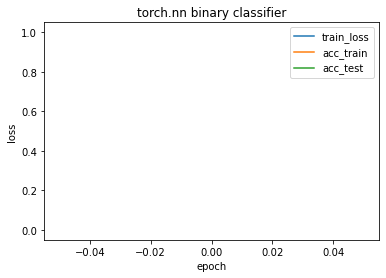

running time 0.8002612590789795


In [108]:
NetBinaryClassifierWithNN = nn.Sequential(
    nn.Flatten(),
    nn.Linear(200, 1),
    nn.Sigmoid()
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

NetBinaryClassifierWithNN.apply(init_weights)

start = time.time()

lr = 0.1
epochs = 1  # 只遍历一次
net = NetBinaryClassifierWithNN

loss = nn.BCELoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
batch_size = 100
eval = evaluate_acc_binary_classifier

train_binary_classifier_withNN(net, loss, x_train, x_test, y_train, y_test, epochs, batch_size, optimizer, eval,'torch.nn binary classifier')

end= time.time()
print("running time", (end-start))

### 4.2.3 具体情况分析
这里我们把 epoch 改成1，在y_hat后边输出，这样就可以知道计算出的y_hat，发现几个小batch_size之后就可以发现数据完成变成了0或1，这就解释了为什么acc 是1.0

# 5.手动实现多分类
## 5.1 基本函数编写

因为 MNIST数据集下载过慢，考虑到本地GPU资源不足，转移到Colab上完成本实验。
见文件2

In [306]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [312]:
train_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST/", train=True, transform= transforms.ToTensor(), download=True)
test_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST", train=False, transform= transforms.ToTensor(), download=True)

Using downloaded and verified file: ../Datasets/MNIST/MNIST\raw\train-images-idx3-ubyte.gz
Extracting ../Datasets/MNIST/MNIST\raw\train-images-idx3-ubyte.gz to ../Datasets/MNIST/MNIST\raw

Using downloaded and verified file: ../Datasets/MNIST/MNIST\raw\train-labels-idx1-ubyte.gz
Extracting ../Datasets/MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to ../Datasets/MNIST/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../Datasets/MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to ../Datasets/MNIST/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../Datasets/MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../Datasets/MNIST/MNIST\raw



---